# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN 
from sklearn.model_selection import cross_val_predict, LeaveOneOut, GridSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, RidgeClassifier, RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
# !pip install xgboost
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB
# !pip install tqdm
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# Define functions

In [10]:
# Create instances of all models to investigate
LR_mod = LogisticRegression(random_state = 42)
PTN_mod = Perceptron(random_state = 42)
SGD_mod = SGDClassifier(random_state = 42)
RDG_mod = RidgeClassifier(random_state = 42)
RDGCV_mod = RidgeClassifierCV()
DT_mod = DecisionTreeClassifier(random_state = 42)
ET_mod = ExtraTreeClassifier(random_state = 42)
RF_mod = RandomForestClassifier(random_state = 42)
ETS_mod = ExtraTreesClassifier(random_state = 42)
ADB_mod = AdaBoostClassifier(random_state = 42)
BAG_mod = BaggingClassifier(random_state = 42)
XGB_mod = XGBClassifier(random_state = 42)
LFBM_mod = lgb.LGBMClassifier(random_state = 42)
KNN_mod = KNeighborsClassifier()
NC_mod  = NearestCentroid()
LSVC_mod = LinearSVC(random_state = 42)
NSVC_mod = NuSVC(random_state = 42)
SVC_mod = SVC(random_state = 42)
BNB_mod = BernoulliNB()
GNB_mod = GaussianNB()

# Create alist of defined model instances
models = [LR_mod, PTN_mod, SGD_mod, RDG_mod, RDGCV_mod,
          DT_mod, ET_mod, RF_mod, ETS_mod, ADB_mod, BAG_mod,
          XGB_mod, LFBM_mod, KNN_mod, NC_mod, LSVC_mod, NSVC_mod,
          SVC_mod, BNB_mod, GNB_mod]

# Create a list of model names without parentheses
model_names = [model.__class__.__name__ for model in models]
model_names

['LogisticRegression',
 'Perceptron',
 'SGDClassifier',
 'RidgeClassifier',
 'RidgeClassifierCV',
 'DecisionTreeClassifier',
 'ExtraTreeClassifier',
 'RandomForestClassifier',
 'ExtraTreesClassifier',
 'AdaBoostClassifier',
 'BaggingClassifier',
 'XGBClassifier',
 'LGBMClassifier',
 'KNeighborsClassifier',
 'NearestCentroid',
 'LinearSVC',
 'NuSVC',
 'SVC',
 'BernoulliNB',
 'GaussianNB']

In [12]:
# Degine a function that performs leave one out cross validation on the list of models 
# and populate a dataframe with each model and its metrics
def train_models(X, y, models):
    metrics_names = [
        'Model', 'Accuracy', 'Sensitivity', 'Specificity',
        'Positive Predictive Value', 'Negative Predictive Value',
        'F1-score', 'False Positive Rate', 'True Positive Rate']
    
    all_metrics = pd.DataFrame(columns=metrics_names)
    
    for model in tqdm(models, desc="Training Models", unit="model"):
        metrics = evaluate_model(model, X, y)
        metrics_series = pd.Series(metrics, index=metrics_names)
        metrics_df = metrics_series.to_frame().T
        all_metrics = pd.concat([all_metrics, metrics_df], ignore_index=True)
        print("{} - successfully trained".format(model))
    all_metrics['Model'] = model_names
    all_metrics_sorted = all_metrics.sort_values(by='F1-score', ascending=False)
    
    return all_metrics_sorted

In [11]:
# Define a function that trains and tests a model using leave one out
# cross validation and returns a list of evaluation metrics

def evaluate_model(model, X, y):
    # Perform leave one out cross validation
    cv = LeaveOneOut()
    pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

    # Calculate evaluation metrics
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    sen = (tp) / (tp + fn)
    spec = (tn) / (tn + fp)
    ppv = (tp) / (tp + fp)
    npv = (tn) / (tn + fn)
    f1 = 2 * (sen * ppv) / (sen + ppv)
    fpr = (fp) / (fp + tn)
    tpr = (tp) / (tp + fn)

    # Creating a tuple of calculated metrics
    metrics_tuple = (model, acc, sen, spec, ppv, npv, f1, fpr, tpr)

    return metrics_tuple

# Data import and inspection

In [2]:
# Import and view data
data = pd.read_csv(r"C:\Users\rm8l\Documents\data\PET for NSCLC nodal staging.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Gender                  230 non-null    object 
 1   Age                     230 non-null    int64  
 2   Nodal station           230 non-null    object 
 3   MBP SUVmax              230 non-null    float64
 4   Node SUVmax             230 non-null    float64
 5   Primary SUVmax          230 non-null    float64
 6   Node short axis diam    230 non-null    float64
 7   Primary long axis diam  230 non-null    int64  
 8   EBUS cytology           230 non-null    object 
dtypes: float64(4), int64(2), object(3)
memory usage: 16.3+ KB


,Gender,Age,Nodal station,MBP SUVmax,Node SUVmax,Primary SUVmax,Node short axis diam,Primary long axis diam,EBUS cytology
0,F,64,10L,1.4,3.0,7.4,5.0,12,N
1,F,56,10L,2.2,16.8,16.8,40.0,54,N
2,F,64,10R,1.4,2.5,7.4,7.0,12,N
3,M,85,10R,2.2,5.9,7.1,9.0,14,N
4,F,66,10R,2.4,0.0,30.5,0.0,32,N


# Data preparation

In [3]:
# Convert label into binary 0 and 1
le = LabelEncoder()
data['EBUS cytology'] = le.fit_transform(data['EBUS cytology'])

# Remove unwanted data not relevant to investigation
data = data.drop(['Nodal station'], axis=1)

# One hot encode catagorical variables (gender)
data = pd.get_dummies(data)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     230 non-null    int64  
 1   MBP SUVmax              230 non-null    float64
 2   Node SUVmax             230 non-null    float64
 3   Primary SUVmax          230 non-null    float64
 4   Node short axis diam    230 non-null    float64
 5   Primary long axis diam  230 non-null    int64  
 6   EBUS cytology           230 non-null    int32  
 7   Gender_F                230 non-null    uint8  
 8   Gender_M                230 non-null    uint8  
dtypes: float64(4), int32(1), int64(2), uint8(2)
memory usage: 12.3 KB


,Age,MBP SUVmax,Node SUVmax,Primary SUVmax,Node short axis diam,Primary long axis diam,EBUS cytology,Gender_F,Gender_M
0,64,1.4,3.0,7.4,5.0,12,0,1,0
1,56,2.2,16.8,16.8,40.0,54,0,1,0
2,64,1.4,2.5,7.4,7.0,12,0,1,0
3,85,2.2,5.9,7.1,9.0,14,0,0,1
4,66,2.4,0.0,30.5,0.0,32,0,1,0


In [4]:
# Apply an insignificant value to all features to eliminate 0 values
# causing infinity when feature engineering
data[['MBP SUVmax', 'Node SUVmax', 'Primary SUVmax', 'Primary long axis diam',
      'Node short axis diam']] = data[['MBP SUVmax', 'Node SUVmax',
                                       'Primary SUVmax',
                                       'Primary long axis diam',
                                       'Node short axis diam'
                                       ]].apply(lambda x: x + 0.001)
# Feature engineering
data['prim-mbp'] = data['Primary SUVmax'] - data['MBP SUVmax']
data['Node-mbp'] = data['Node SUVmax'] - data['MBP SUVmax']
data['Node-prim'] = data['Node SUVmax'] - data['Primary SUVmax']
data['prim/mbp'] = data['Primary SUVmax'] / data['MBP SUVmax']
data['Node/mbp'] = data['Node SUVmax'] / data['MBP SUVmax']
data['Node/prim'] = data['Node SUVmax'] / data['Primary SUVmax']
data['Node diam/Prim diam'] = data['Node short axis diam'] / data['Primary long axis diam']
data['Node SUV/Node diam'] = data['Node SUVmax'] / data['Node short axis diam']
data['Prim SUV/Prim diam'] = data['Primary SUVmax'] / data['Primary long axis diam']

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     230 non-null    int64  
 1   MBP SUVmax              230 non-null    float64
 2   Node SUVmax             230 non-null    float64
 3   Primary SUVmax          230 non-null    float64
 4   Node short axis diam    230 non-null    float64
 5   Primary long axis diam  230 non-null    float64
 6   EBUS cytology           230 non-null    int32  
 7   Gender_F                230 non-null    uint8  
 8   Gender_M                230 non-null    uint8  
 9   prim-mbp                230 non-null    float64
 10  Node-mbp                230 non-null    float64
 11  Node-prim               230 non-null    float64
 12  prim/mbp                230 non-null    float64
 13  Node/mbp                230 non-null    float64
 14  Node/prim               230 non-null    fl

,Age,MBP SUVmax,Node SUVmax,Primary SUVmax,Node short axis diam,Primary long axis diam,EBUS cytology,Gender_F,Gender_M,prim-mbp,Node-mbp,Node-prim,prim/mbp,Node/mbp,Node/prim,Node diam/Prim diam,Node SUV/Node diam,Prim SUV/Prim diam
0,64,1.401,3.001,7.401,5.001,12.001,0,1,0,6.0,1.6,-4.4,5.282655,2.142041,0.405486,0.416715,0.600080,0.616699
1,56,2.201,16.801,16.801,40.001,54.001,0,1,0,14.6,14.6,0.0,7.633348,7.633348,1.000000,0.740746,0.420014,0.311124
2,64,1.401,2.501,7.401,7.001,12.001,0,1,0,6.0,1.1,-4.9,5.282655,1.785153,0.337927,0.583368,0.357235,0.616699
3,85,2.201,5.901,7.101,9.001,14.001,0,0,1,4.9,3.7,-1.2,3.226261,2.681054,0.831010,0.642883,0.655594,0.507178
4,66,2.401,0.001,30.501,0.001,32.001,0,1,0,28.1,-2.4,-30.5,12.703457,0.000416,0.000033,0.000031,1.000000,0.953126


<AxesSubplot:xlabel='EBUS cytology', ylabel='Count'>

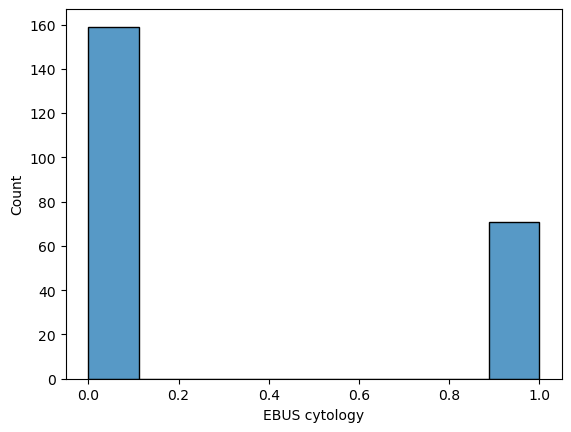

In [5]:
# Split data into features and labels
X = data.drop(['EBUS cytology'], axis=1)
y = data['EBUS cytology']
sns.histplot(y)

In [6]:
N = 300
samp = {0:N,1:N}

C:\Users\rm8l\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (300) in class 0 will be larger than the number of samples in the majority class (class #0 -> 159)
  warnings.warn(
C:\Users\rm8l\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (300) in class 1 will be larger than the number of samples in the majority class (class #0 -> 159)
  warnings.warn(


<AxesSubplot:xlabel='EBUS cytology', ylabel='Count'>

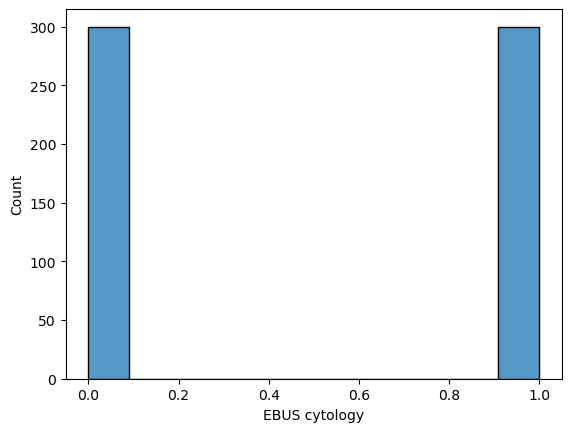

In [7]:
# USe SMOTE to balance classes
smt = SMOTE(sampling_strategy=samp)
X_smt, y_smt = smt.fit_resample(X, y)
sns.histplot(y_smt)

C:\Users\rm8l\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (300) in class 0 will be larger than the number of samples in the majority class (class #0 -> 159)
  warnings.warn(
C:\Users\rm8l\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (300) in class 1 will be larger than the number of samples in the majority class (class #0 -> 159)
  warnings.warn(


<AxesSubplot:xlabel='EBUS cytology', ylabel='Count'>

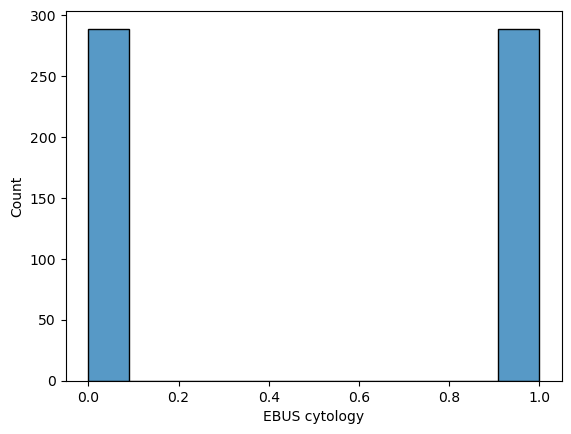

In [8]:
# Use adasyn to balance classes
samp = {0:N,1:N}
ada = ADASYN(sampling_strategy=samp)
X_ada, y_ada = ada.fit_resample(X, y)
sns.histplot(y_ada)

In [9]:
# Scale features
scaler = StandardScaler()
X_smt_scaled = scaler.fit_transform(X_smt)
X_ada_scaled = scaler.fit_transform(X_ada)

# Model training

In [13]:
# Perfrom model evaluation on SMOTE scaled data
smt_scaled_results = train_models(X_smt_scaled, y_smt, models)
smt_scaled_results

Training Models:   5%|███▏                                                           | 1/20 [00:17<05:30, 17.39s/model]

LogisticRegression(random_state=42) - successfully trained


Training Models:  10%|██████▎                                                        | 2/20 [00:18<02:16,  7.58s/model]

Perceptron(random_state=42) - successfully trained


Training Models:  15%|█████████▍                                                     | 3/20 [00:19<01:17,  4.55s/model]

SGDClassifier(random_state=42) - successfully trained


Training Models:  20%|████████████▌                                                  | 4/20 [00:19<00:48,  3.03s/model]

RidgeClassifier(random_state=42) - successfully trained


Training Models:  25%|███████████████▊                                               | 5/20 [00:20<00:34,  2.27s/model]

RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])) - successfully trained


Training Models:  30%|██████████████████▉                                            | 6/20 [00:22<00:28,  2.07s/model]

DecisionTreeClassifier(random_state=42) - successfully trained


Training Models:  35%|██████████████████████                                         | 7/20 [00:22<00:20,  1.59s/model]

ExtraTreeClassifier(random_state=42) - successfully trained


Training Models:  40%|█████████████████████████▏                                     | 8/20 [01:13<03:26, 17.24s/model]

RandomForestClassifier(random_state=42) - successfully trained


Training Models:  45%|████████████████████████████▎                                  | 9/20 [01:48<04:11, 22.87s/model]

ExtraTreesClassifier(random_state=42) - successfully trained


Training Models:  50%|███████████████████████████████                               | 10/20 [02:15<04:00, 24.03s/model]

AdaBoostClassifier(random_state=42) - successfully trained


Training Models:  55%|██████████████████████████████████                            | 11/20 [02:25<02:58, 19.78s/model]

BaggingClassifier(random_state=42) - successfully trained


Training Models:  60%|█████████████████████████████████████▏                        | 12/20 [02:51<02:52, 21.54s/model]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...) - successfully trained


Training Models:  65%|████████████████████████████████████████▎                     | 13/20 [03:16<02:38, 22.70s/model]

LGBMClassifier(random_state=42) - successfully trained


Training Models:  70%|███████████████████████████████████████████▍                  | 14/20 [03:17<01:36, 16.09s/model]

KNeighborsClassifier() - successfully trained


Training Models:  75%|██████████████████████████████████████████████▌               | 15/20 [03:17<00:56, 11.39s/model]

NearestCentroid() - successfully trained


Training Models:  80%|█████████████████████████████████████████████████▌            | 16/20 [03:27<00:43, 10.81s/model]

LinearSVC(random_state=42) - successfully trained


Training Models:  85%|████████████████████████████████████████████████████▋         | 17/20 [03:33<00:27,  9.32s/model]

NuSVC(random_state=42) - successfully trained


Training Models:  90%|███████████████████████████████████████████████████████▊      | 18/20 [03:36<00:15,  7.59s/model]

SVC(random_state=42) - successfully trained


Training Models:  95%|██████████████████████████████████████████████████████████▉   | 19/20 [03:37<00:05,  5.48s/model]

BernoulliNB() - successfully trained


Training Models: 100%|██████████████████████████████████████████████████████████████| 20/20 [03:37<00:00, 10.90s/model]

GaussianNB() - successfully trained


,Model,Accuracy,Sensitivity,Specificity,Positive Predictive Value,Negative Predictive Value,F1-score,False Positive Rate,True Positive Rate
12,LGBMClassifier,0.936667,0.946667,0.926667,0.928105,0.945578,0.937294,0.073333,0.946667
11,XGBClassifier,0.931667,0.946667,0.916667,0.919094,0.945017,0.932677,0.083333,0.946667
8,ExtraTreesClassifier,0.931667,0.94,0.923333,0.92459,0.938983,0.932231,0.076667,0.94
7,RandomForestClassifier,0.916667,0.93,0.903333,0.905844,0.928082,0.917763,0.096667,0.93
13,KNeighborsClassifier,0.913333,0.936667,0.89,0.894904,0.933566,0.915309,0.11,0.936667
17,SVC,0.911667,0.896667,0.926667,0.924399,0.899676,0.910321,0.073333,0.896667
10,BaggingClassifier,0.91,0.91,0.91,0.91,0.91,0.91,0.09,0.91
9,AdaBoostClassifier,0.91,0.906667,0.913333,0.912752,0.907285,0.909699,0.086667,0.906667
16,NuSVC,0.89,0.853333,0.926667,0.920863,0.863354,0.885813,0.073333,0.853333
5,DecisionTreeClassifier,0.883333,0.886667,0.88,0.880795,0.885906,0.883721,0.12,0.886667


In [14]:
# Perfrom model evaluation on SMOTE un-scaled data
smt_results = train_models(X_smt, y_smt, models)
smt_results

Training Models:   5%|███▏                                                           | 1/20 [00:09<02:58,  9.39s/model]

LogisticRegression(random_state=42) - successfully trained


Training Models:  10%|██████▎                                                        | 2/20 [00:11<01:29,  4.95s/model]

Perceptron(random_state=42) - successfully trained


Training Models:  15%|█████████▍                                                     | 3/20 [00:12<00:58,  3.45s/model]

SGDClassifier(random_state=42) - successfully trained


Training Models:  20%|████████████▌                                                  | 4/20 [00:14<00:40,  2.56s/model]

RidgeClassifier(random_state=42) - successfully trained


Training Models:  25%|███████████████▊                                               | 5/20 [00:15<00:32,  2.16s/model]

RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])) - successfully trained


Training Models:  30%|██████████████████▉                                            | 6/20 [00:17<00:29,  2.13s/model]

DecisionTreeClassifier(random_state=42) - successfully trained


Training Models:  35%|██████████████████████                                         | 7/20 [00:18<00:23,  1.79s/model]

ExtraTreeClassifier(random_state=42) - successfully trained


Training Models:  40%|█████████████████████████▏                                     | 8/20 [01:11<03:35, 17.98s/model]

RandomForestClassifier(random_state=42) - successfully trained


Training Models:  45%|████████████████████████████▎                                  | 9/20 [01:49<04:26, 24.24s/model]

ExtraTreesClassifier(random_state=42) - successfully trained


Training Models:  50%|███████████████████████████████                               | 10/20 [02:17<04:14, 25.49s/model]

AdaBoostClassifier(random_state=42) - successfully trained


Training Models:  55%|██████████████████████████████████                            | 11/20 [02:28<03:09, 21.02s/model]

BaggingClassifier(random_state=42) - successfully trained


Training Models:  60%|█████████████████████████████████████▏                        | 12/20 [02:57<03:08, 23.50s/model]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...) - successfully trained


Training Models:  65%|████████████████████████████████████████▎                     | 13/20 [03:19<02:40, 22.88s/model]

LGBMClassifier(random_state=42) - successfully trained


Training Models:  70%|███████████████████████████████████████████▍                  | 14/20 [03:20<01:38, 16.35s/model]

KNeighborsClassifier() - successfully trained


Training Models:  75%|██████████████████████████████████████████████▌               | 15/20 [03:21<00:58, 11.71s/model]

NearestCentroid() - successfully trained


Training Models:  80%|█████████████████████████████████████████████████▌            | 16/20 [03:30<00:44, 11.07s/model]

LinearSVC(random_state=42) - successfully trained


Training Models:  85%|████████████████████████████████████████████████████▋         | 17/20 [03:37<00:29,  9.75s/model]

NuSVC(random_state=42) - successfully trained


Training Models:  90%|███████████████████████████████████████████████████████▊      | 18/20 [03:45<00:18,  9.25s/model]

SVC(random_state=42) - successfully trained


Training Models:  95%|██████████████████████████████████████████████████████████▉   | 19/20 [03:46<00:06,  6.84s/model]

BernoulliNB() - successfully trained


Training Models: 100%|██████████████████████████████████████████████████████████████| 20/20 [03:48<00:00, 11.41s/model]

GaussianNB() - successfully trained


,Model,Accuracy,Sensitivity,Specificity,Positive Predictive Value,Negative Predictive Value,F1-score,False Positive Rate,True Positive Rate
12,LGBMClassifier,0.938333,0.95,0.926667,0.928339,0.948805,0.939044,0.073333,0.95
8,ExtraTreesClassifier,0.936667,0.94,0.933333,0.933775,0.939597,0.936877,0.066667,0.94
11,XGBClassifier,0.933333,0.95,0.916667,0.919355,0.948276,0.934426,0.083333,0.95
13,KNeighborsClassifier,0.931667,0.933333,0.93,0.930233,0.93311,0.93178,0.07,0.933333
7,RandomForestClassifier,0.921667,0.936667,0.906667,0.909385,0.934708,0.922824,0.093333,0.936667
9,AdaBoostClassifier,0.911667,0.9,0.923333,0.921502,0.90228,0.910624,0.076667,0.9
10,BaggingClassifier,0.906667,0.906667,0.906667,0.906667,0.906667,0.906667,0.093333,0.906667
5,DecisionTreeClassifier,0.881667,0.883333,0.88,0.880399,0.882943,0.881864,0.12,0.883333
6,ExtraTreeClassifier,0.87,0.873333,0.866667,0.86755,0.872483,0.870432,0.133333,0.873333
0,LogisticRegression,0.87,0.816667,0.923333,0.914179,0.834337,0.862676,0.076667,0.816667


In [15]:
# Perfrom model evaluation on ADASYN scaled data
ada_scaled_results = train_models(X_ada_scaled, y_ada, models)
ada_scaled_results

Training Models:   5%|███▏                                                           | 1/20 [00:03<01:00,  3.20s/model]

LogisticRegression(random_state=42) - successfully trained


Training Models:  10%|██████▎                                                        | 2/20 [00:03<00:31,  1.78s/model]

Perceptron(random_state=42) - successfully trained


Training Models:  15%|█████████▍                                                     | 3/20 [00:05<00:24,  1.47s/model]

SGDClassifier(random_state=42) - successfully trained


Training Models:  20%|████████████▌                                                  | 4/20 [00:05<00:19,  1.20s/model]

RidgeClassifier(random_state=42) - successfully trained


Training Models:  25%|███████████████▊                                               | 5/20 [00:06<00:16,  1.09s/model]

RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])) - successfully trained


Training Models:  30%|██████████████████▉                                            | 6/20 [00:08<00:16,  1.15s/model]

DecisionTreeClassifier(random_state=42) - successfully trained


Training Models:  35%|██████████████████████                                         | 7/20 [00:08<00:12,  1.01model/s]

ExtraTreeClassifier(random_state=42) - successfully trained


Training Models:  40%|█████████████████████████▏                                     | 8/20 [00:58<03:19, 16.64s/model]

RandomForestClassifier(random_state=42) - successfully trained


Training Models:  45%|████████████████████████████▎                                  | 9/20 [01:36<04:15, 23.25s/model]

ExtraTreesClassifier(random_state=42) - successfully trained


Training Models:  50%|███████████████████████████████                               | 10/20 [02:11<04:27, 26.71s/model]

AdaBoostClassifier(random_state=42) - successfully trained


Training Models:  55%|██████████████████████████████████                            | 11/20 [02:24<03:24, 22.76s/model]

BaggingClassifier(random_state=42) - successfully trained


Training Models:  60%|█████████████████████████████████████▏                        | 12/20 [03:01<03:35, 26.96s/model]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...) - successfully trained


Training Models:  65%|████████████████████████████████████████▎                     | 13/20 [03:30<03:13, 27.61s/model]

LGBMClassifier(random_state=42) - successfully trained


Training Models:  70%|███████████████████████████████████████████▍                  | 14/20 [03:31<01:57, 19.53s/model]

KNeighborsClassifier() - successfully trained


Training Models:  75%|██████████████████████████████████████████████▌               | 15/20 [03:31<01:09, 13.81s/model]

NearestCentroid() - successfully trained


Training Models:  80%|█████████████████████████████████████████████████▌            | 16/20 [03:41<00:49, 12.47s/model]

LinearSVC(random_state=42) - successfully trained


Training Models:  85%|████████████████████████████████████████████████████▋         | 17/20 [03:46<00:30, 10.25s/model]

NuSVC(random_state=42) - successfully trained


Training Models:  90%|███████████████████████████████████████████████████████▊      | 18/20 [03:50<00:16,  8.28s/model]

SVC(random_state=42) - successfully trained


Training Models:  95%|██████████████████████████████████████████████████████████▉   | 19/20 [03:50<00:05,  5.98s/model]

BernoulliNB() - successfully trained


Training Models: 100%|██████████████████████████████████████████████████████████████| 20/20 [03:51<00:00, 11.57s/model]

GaussianNB() - successfully trained


,Model,Accuracy,Sensitivity,Specificity,Positive Predictive Value,Negative Predictive Value,F1-score,False Positive Rate,True Positive Rate
12,LGBMClassifier,0.944637,0.961938,0.927336,0.929766,0.960573,0.945578,0.072664,0.961938
8,ExtraTreesClassifier,0.934256,0.948097,0.920415,0.922559,0.946619,0.935154,0.079585,0.948097
11,XGBClassifier,0.925606,0.941176,0.910035,0.912752,0.939286,0.926746,0.089965,0.941176
7,RandomForestClassifier,0.920415,0.937716,0.903114,0.906355,0.935484,0.921769,0.096886,0.937716
13,KNeighborsClassifier,0.901384,0.923875,0.878893,0.884106,0.92029,0.903553,0.121107,0.923875
10,BaggingClassifier,0.889273,0.906574,0.871972,0.876254,0.903226,0.891156,0.128028,0.906574
9,AdaBoostClassifier,0.880623,0.910035,0.851211,0.859477,0.904412,0.884034,0.148789,0.910035
5,DecisionTreeClassifier,0.873702,0.885813,0.861592,0.864865,0.882979,0.875214,0.138408,0.885813
17,SVC,0.865052,0.885813,0.844291,0.850498,0.880866,0.867797,0.155709,0.885813
16,NuSVC,0.865052,0.885813,0.844291,0.850498,0.880866,0.867797,0.155709,0.885813


In [16]:
# Perfrom model evaluation on ADASYN un-scaled data
ada_results = train_models(X_ada, y_ada, models)
ada_results

Training Models:   5%|███▏                                                           | 1/20 [00:12<03:54, 12.36s/model]

LogisticRegression(random_state=42) - successfully trained


Training Models:  10%|██████▎                                                        | 2/20 [00:13<01:45,  5.87s/model]

Perceptron(random_state=42) - successfully trained


Training Models:  15%|█████████▍                                                     | 3/20 [00:15<01:09,  4.07s/model]

SGDClassifier(random_state=42) - successfully trained


Training Models:  20%|████████████▌                                                  | 4/20 [00:16<00:46,  2.93s/model]

RidgeClassifier(random_state=42) - successfully trained


Training Models:  25%|███████████████▊                                               | 5/20 [00:18<00:35,  2.36s/model]

RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])) - successfully trained


Training Models:  30%|██████████████████▉                                            | 6/20 [00:19<00:29,  2.14s/model]

DecisionTreeClassifier(random_state=42) - successfully trained


Training Models:  35%|██████████████████████                                         | 7/20 [00:20<00:23,  1.79s/model]

ExtraTreeClassifier(random_state=42) - successfully trained


Training Models:  40%|█████████████████████████▏                                     | 8/20 [01:16<03:47, 18.95s/model]

RandomForestClassifier(random_state=42) - successfully trained


Training Models:  45%|████████████████████████████▎                                  | 9/20 [01:51<04:22, 23.89s/model]

ExtraTreesClassifier(random_state=42) - successfully trained


Training Models:  50%|███████████████████████████████                               | 10/20 [02:17<04:06, 24.62s/model]

AdaBoostClassifier(random_state=42) - successfully trained


Training Models:  55%|██████████████████████████████████                            | 11/20 [02:27<03:02, 20.23s/model]

BaggingClassifier(random_state=42) - successfully trained


Training Models:  60%|█████████████████████████████████████▏                        | 12/20 [02:57<03:05, 23.22s/model]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...) - successfully trained


Training Models:  65%|████████████████████████████████████████▎                     | 13/20 [03:15<02:31, 21.58s/model]

LGBMClassifier(random_state=42) - successfully trained


Training Models:  70%|███████████████████████████████████████████▍                  | 14/20 [03:17<01:32, 15.49s/model]

KNeighborsClassifier() - successfully trained


Training Models:  75%|██████████████████████████████████████████████▌               | 15/20 [03:18<00:55, 11.12s/model]

NearestCentroid() - successfully trained


Training Models:  80%|█████████████████████████████████████████████████▌            | 16/20 [03:28<00:43, 10.96s/model]

LinearSVC(random_state=42) - successfully trained


Training Models:  85%|████████████████████████████████████████████████████▋         | 17/20 [03:34<00:27,  9.27s/model]

NuSVC(random_state=42) - successfully trained


Training Models:  90%|███████████████████████████████████████████████████████▊      | 18/20 [03:41<00:17,  8.58s/model]

SVC(random_state=42) - successfully trained


Training Models:  95%|██████████████████████████████████████████████████████████▉   | 19/20 [03:42<00:06,  6.35s/model]

BernoulliNB() - successfully trained


Training Models: 100%|██████████████████████████████████████████████████████████████| 20/20 [03:43<00:00, 11.17s/model]

GaussianNB() - successfully trained


,Model,Accuracy,Sensitivity,Specificity,Positive Predictive Value,Negative Predictive Value,F1-score,False Positive Rate,True Positive Rate
12,LGBMClassifier,0.946367,0.961938,0.930796,0.932886,0.960714,0.947189,0.069204,0.961938
8,ExtraTreesClassifier,0.935986,0.951557,0.920415,0.922819,0.95,0.936968,0.079585,0.951557
11,XGBClassifier,0.929066,0.944637,0.913495,0.916107,0.942857,0.930153,0.086505,0.944637
7,RandomForestClassifier,0.923875,0.937716,0.910035,0.912458,0.935943,0.924915,0.089965,0.937716
13,KNeighborsClassifier,0.908304,0.923875,0.892734,0.895973,0.921429,0.90971,0.107266,0.923875
10,BaggingClassifier,0.891003,0.906574,0.875433,0.879195,0.903571,0.892675,0.124567,0.906574
5,DecisionTreeClassifier,0.873702,0.885813,0.861592,0.864865,0.882979,0.875214,0.138408,0.885813
9,AdaBoostClassifier,0.870242,0.899654,0.84083,0.849673,0.893382,0.87395,0.15917,0.899654
6,ExtraTreeClassifier,0.856401,0.858131,0.854671,0.855172,0.857639,0.856649,0.145329,0.858131
3,RidgeClassifier,0.738754,0.712803,0.764706,0.751825,0.726974,0.731794,0.235294,0.712803


In [37]:
# Determine which training run gave best f1 score

# Extract f1 score values from each dataframe
f1_scores = {
    'smt_scaled_results': smt_scaled_results.iloc[0, 6],
    'smt_results': smt_results.iloc[0, 6],
    'ada_scaled_results': ada_scaled_results.iloc[0, 6],
    'ada_results': ada_results.iloc[0, 6]
}

# Find the maximum f1 score value and corresponding dataframe name
max_value = max(f1_scores.values())
df_with_max_value = [df_name for df_name, 
                          value in f1_scores.items() if value == max_value]

# If there are multiple dataframes with the same maximum value, return all their names
print("Training with highest f1 score:", df_with_max_value)


Training with highest f1 score: ['ada_results']


In [49]:
# Identify the best performing model according to F1 score
best_model_name = ada_results.iloc[0]['Model']
best_model_index = model_names.index(best_model_name)
best_model = models[best_model_index]

# Perform leave one out cross validation on the best model to obtian predictions
cv = LeaveOneOut()
best_pred = cross_val_predict(best_model, X_smt_scaled, y_smt, cv = cv, n_jobs=-1)

# Combine predicitons and actual class label into dataframe
y = np.array(y)
best_results = np.stack((y_smt, best_pred), axis=1)
best_results = pd.DataFrame(best_results,
                   columns=['Actual', 'Predictions'])
print(best_model_name, "training complete")

LGBMClassifier training complete


# Best model summary evaluation 

Performance metrics for the best performing model 

 BEST MODEL: LGBMClassifier(random_state=42) 

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       300
           1       0.93      0.95      0.94       300

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



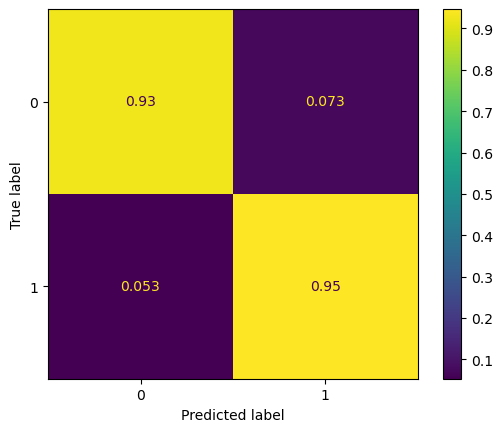

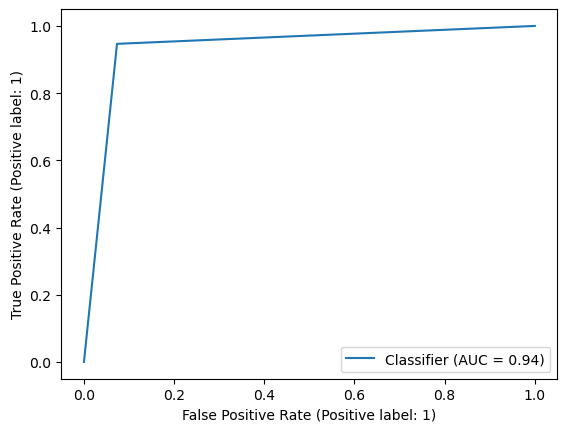

In [50]:
# Display best model performance metrics
print("Performance metrics for the best performing model \n\n BEST MODEL: {} \n".format(best_model))

print(ConfusionMatrixDisplay.from_predictions(best_results['Actual'],
                                              best_results['Predictions'], normalize= "true"))

print(classification_report(best_results['Actual'],
                            best_results['Predictions']))

print(RocCurveDisplay.from_predictions(best_results['Actual'],
                                       best_results['Predictions']))

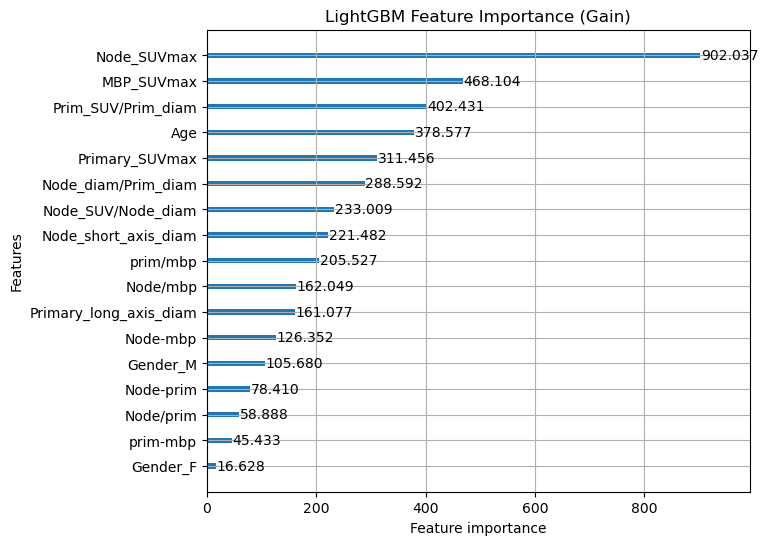

In [58]:
lgb.plot_importance(best_model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

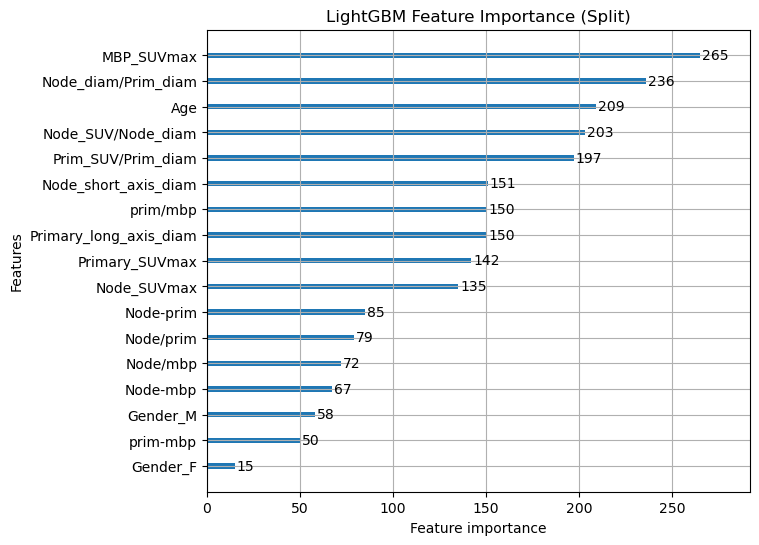

In [60]:
lgb.plot_importance(best_model, importance_type="split", figsize=(7,6), 
                    title="LightGBM Feature Importance (Split)")
plt.show()